# NLP Project: Sentiment Analysis from Tweets

In [1]:
import csv                               # csv reader
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
import numpy as np

In [2]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))

def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process(text)),label))
    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(pre_process(text)),label))

# Input and Basic preprocessing

In [3]:
# I have created a function to extract and return the label and text from the input data line
def parse_data_line(data):
    return (data[1], data[2])

In [4]:

# Importing the libraries for the text pre-processing task
import regex as re
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import string

# I am creating a function to perform basic preprocessing task
def pre_process(text):
    processed_texts = []
    # for removing URL's
    text = re.sub(r'http\S+', '', text)
    # removing emojis
    text = re.sub(r"\p{Emoji}", "", text)
    # separate punctuations at ends of strings
    text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text)
    # separate punctuations at beginning of strings
    text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", text)
    # Removal of special charaters '@' and '#'
    text = re.sub(r"[@#]", "", text)
    print("tokenising:", text)
    # Tokenize the text
    tokens = re.split(r"\s+",text)

    # normalisation covert the tokens to lowercase
    tokens = [t.lower() for t in tokens]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Add processed tokens to the list
    processed_texts.append(tokens)
    return tokens

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [5]:
# File path for the dataset
file_path = "sentiment-dataset.tsv"
#read the file with csv reader
with open(file_path) as f:
    reader = csv.reader(f, delimiter='\t')
    #Iterate through each line in the file
    for line in reader:
        if line[0] == "Id":  # skip header
            continue
        # i am Extracting label and text using the parse_data_line function
        label, text = parse_data_line(line)
        # i am doing Preprocess of the text using the pre_process function
        tokens = pre_process(text)

        # Printing the results
        print("Label:", label)
        print("Tokens:", tokens)
        print("\n")

Streaming output truncated to the last 5000 lines.
tokenising: David Beckham may have just passed Taylor Swift on the good deeds list ... check this out ! 
Label: positive
Tokens: ['david', 'beckham', 'may', 'have', 'just', 'passed', 'taylor', 'swift', 'on', 'the', 'good', 'deed', 'list', '...', 'check', 'this', 'out', '!', '']


tokenising: Beyonce is probably the best female Virgo I never met , nd to my girl yahtesh lol
Label: positive
Tokens: ['beyonce', 'is', 'probably', 'the', 'best', 'female', 'virgo', 'i', 'never', 'met', ',', 'nd', 'to', 'my', 'girl', 'yahtesh', 'lol']


tokenising: SenateDems SenateGOP drug prices are damaging American health systems .  We need AUDIT of MEDICARE drug price hikes 
Label: negative
Tokens: ['senatedems', 'senategop', 'drug', 'price', 'are', 'damaging', 'american', 'health', 'system', '.', 'we', 'need', 'audit', 'of', 'medicare', 'drug', 'price', 'hike', '']


tokenising: moosehickey megynkelly I watch Fox News every night ! Bill & her are a must 

# Basic Feature Extraction

In [6]:

# A global dictionary to store the cumulative features
global_feature_dict = {}


# importing the necessary libraries for the feature extraction task
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.pipeline import Pipeline

# i have created a function for converting a list of tokens to a TF-IDF feature vector
def to_feature_vector(tokens):
    # Use TF-IDF vectorizer
    vectorizer = TfidfVectorizer()
    feature_vector = vectorizer.fit_transform([' '.join(tokens)])

    # Converting the sparse matrix to a dictionary
    feature_dict = dict(zip(vectorizer.get_feature_names_out(), feature_vector.toarray()[0]))

    # Incrementally build up the global feature dictionary as asked in the question
    for feature, value in feature_dict.items():
        global_feature_dict.setdefault(feature, 0)
        global_feature_dict[feature] += value

    return feature_dict

In [7]:
# the example usage of the to_feature_vector function
global_feature_dict = {}# Reset the global feature dictionary
preprocessed_text = ["this", "is","an", "an","an", "an", "an", "an", "some", "repeated", "tokens", "repeated"]
feature_vector = to_feature_vector(preprocessed_text)
print("Feature Vector:", feature_vector)
print("Global Feature_Dictionary:", global_feature_dict)

Feature Vector: {'an': 0.9045340337332909, 'is': 0.15075567228888181, 'repeated': 0.30151134457776363, 'some': 0.15075567228888181, 'this': 0.15075567228888181, 'tokens': 0.15075567228888181}
Global Feature_Dictionary: {'an': 0.9045340337332909, 'is': 0.15075567228888181, 'repeated': 0.30151134457776363, 'some': 0.15075567228888181, 'this': 0.15075567228888181, 'tokens': 0.15075567228888181}


In [8]:
# TRAINING AND VALIDATING OUR CLASSIFIER
# Function to train a classifier using a provided dataset
def train_classifier(data):
    print("Training Classifier...")
    # creating a pipeline with a LinearSVC classifier
    pipeline =  Pipeline([('svc', LinearSVC(C=0.5))])
    # train the classifier using the provided data
    return SklearnClassifier(pipeline).train(data)

# Cross-validation

In [9]:
#solution
# importing the necessary libraries
from sklearn.metrics import classification_report
import numpy as np
# I have created a function to perform the cross-validation on a the dataset
def cross_validate(dataset, folds):
    results = [] # this is the list to store the performance metrics for each fold
    fold_size = int(len(dataset)/folds) + 1 # for Calculating the size of each fold

    for i in range(0,len(dataset),int(fold_size)):
      # splitting the dataset into training and validation sets for each fold
        validation_data = dataset[i:i + fold_size]
        training_data = dataset[:i] + dataset[i + fold_size:]
         # Train the classifier usingn the training data
        classifier = train_classifier(training_data)

        # Predict labels for the validation set
        predicted_labels = predict_labels([x[0] for x in validation_data], classifier)

        # Evaluate performance using the classification report
        true_labels = [x[1] for x in validation_data]
        report = classification_report(true_labels, predicted_labels, output_dict=True)

        # Store performance metrics for each fold
        results.append({
            'precision': report['weighted avg']['precision'],
            'recall': report['weighted avg']['recall'],
            'f1': report['weighted avg']['f1-score'],
            'accuracy': report['accuracy']
        })

        # Print the fold information
        print("Fold start on items %d - %d" % (i, i + fold_size))
        print(report)
         # for Calculating the average scores across all folds
    average_scores = {
        'precision': np.mean([result['precision'] for result in results]),
        'recall': np.mean([result['recall'] for result in results]),
        'f1': np.mean([result['f1'] for result in results]),
        'accuracy': np.mean([result['accuracy'] for result in results]),
    }
    # printing the average scores
    print("Average Scores:", average_scores)
    return average_scores

In [10]:
# We have been provided with a function to predict labels for a list of samples using a trained classifier

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

# We have been provided with a function to predict label for a raw text sample using a trained classifier
def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(preProcess(reviewSample)))

In [11]:
# i have created several lists to store the raw and preprocessed data
raw_data = []
train_data = []
test_data = []

# file path for the dataset

data_file_path = 'sentiment-dataset.tsv'

# loading the data from the file

print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path)

# spliting the data into trainng and test sets, preprocess the text
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)

# displaying the information about the dataset and the training samples

print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\n')


Streaming output truncated to the last 5000 lines.
tokenising: Saw the PlayStation th Anniversary PS controller up close today . Oh , man , do I want this ( as a huge fan of the original PlayStation ).
tokenising: Fantastic Four tomorrow will it be as good as Ant-Man we ' ll have to see
tokenising: I wish I was out MD I wanna bear on Negros shit is fun , going out Sunday to Ross snighter Sunday Finna pop off on TWL
tokenising: you know you ' re officially into kpop when you spend your Saturday watching the  PathcodeEXO documentaries in between homework LOL
tokenising: David Wright is back and had a big impact in the win tonight . Mets are now  games over ., . games ahead in st , I can see October !
tokenising: At : AM - Hey Yakub , Happy birthday ... May God give you a long life   awkward silence
tokenising: Hey SDuPreeBemis :) Support to the Philippines ? Cybercrime Law to be in full effect tomorrow . Our version of SOPA JunktheCybercrimeLaw
tokenising: I think Frank Ocean should rele

In [12]:

# performing the cross validation on the training data
cross_validate(train_data, 10)

Training Classifier...
Fold start on items 0 - 2684
{'negative': {'precision': 0.844311377245509, 'recall': 0.6894865525672371, 'f1-score': 0.7590847913862718, 'support': 818}, 'positive': {'precision': 0.8740079365079365, 'recall': 0.9442658092175777, 'f1-score': 0.9077794951056157, 'support': 1866}, 'accuracy': 0.8666169895678092, 'macro avg': {'precision': 0.8591596568767228, 'recall': 0.8168761808924074, 'f1-score': 0.8334321432459437, 'support': 2684}, 'weighted avg': {'precision': 0.8649573457938287, 'recall': 0.8666169895678092, 'f1-score': 0.8624619587261733, 'support': 2684}}
Training Classifier...
Fold start on items 2684 - 5368
{'negative': {'precision': 0.7744874715261959, 'recall': 0.5733558178752108, 'f1-score': 0.6589147286821706, 'support': 593}, 'positive': {'precision': 0.887305122494432, 'recall': 0.9526542324246772, 'f1-score': 0.918819188191882, 'support': 2091}, 'accuracy': 0.8688524590163934, 'macro avg': {'precision': 0.830896297010314, 'recall': 0.7630050251499

{'precision': 0.8618368702134592,
 'recall': 0.8633008761436314,
 'f1': 0.8606061460817719,
 'accuracy': 0.8633008761436314}

# Error Analysis

Training Classifier...
{'negative': {'precision': 0.844311377245509, 'recall': 0.6894865525672371, 'f1-score': 0.7590847913862718, 'support': 818}, 'positive': {'precision': 0.8740079365079365, 'recall': 0.9442658092175777, 'f1-score': 0.9077794951056157, 'support': 1866}, 'accuracy': 0.8666169895678092, 'macro avg': {'precision': 0.8591596568767228, 'recall': 0.8168761808924074, 'f1-score': 0.8334321432459437, 'support': 2684}, 'weighted avg': {'precision': 0.8649573457938287, 'recall': 0.8666169895678092, 'f1-score': 0.8624619587261733, 'support': 2684}}
Average Scores: {'precision': 0.8649573457938287, 'recall': 0.8666169895678092, 'f1': 0.8624619587261733, 'accuracy': 0.8666169895678092}


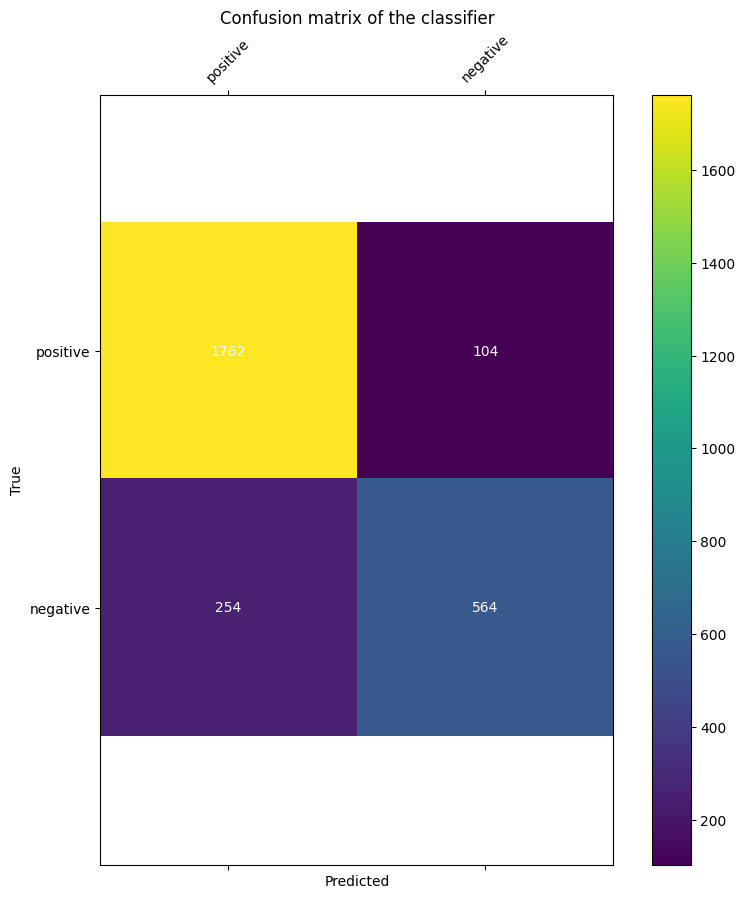

In [13]:

# Importing necessary libraries for thus task
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

# I have created a Function to plot a confusion matrix heatmap
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""

    # I have Calculated the confusion matrix
    cm = metrics.confusion_matrix(y_test, preds, labels=labels)

    # I have Ploted the confusion matrix heatmap
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticklabels(labels)

    # I am Displaying the values in each cell of the matrix
    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Adjusting the limits for a better visualization
    b, t = plt.ylim()
    b += 0.5
    t -= 0.5
    plt.ylim(b, t)
    plt.show()

# creating a Function to perform error analysis on the dataset and generate an output file
def error_analysis(dataset, output_file):
    results = []  # List to store performance metrics
    fold_size = int(len(dataset) / 10) + 1  # Calculate the size of each fold

    # lets Split the dataset into training and validation sets
    validation_data = dataset[0:fold_size]
    training_data = dataset[fold_size:]

    # Now Train the classifier using the training data
    classifier = train_classifier(training_data)

    # I am Predicting the labels for the validation set
    predicted_labels = predict_labels([x[0] for x in validation_data], classifier)

    # I am Evaluating the performance using classification report
    true_labels = [x[1] for x in validation_data]
    report = classification_report(true_labels, predicted_labels, output_dict=True)

    # lets Store the performance metrics
    results.append({
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1': report['weighted avg']['f1-score'],
        'accuracy': report['accuracy']
    })

    # Printing the classification report
    print(report)

    # I have Calculated the average scores
    average_scores = {
        'precision': np.mean([result['precision'] for result in results]),
        'recall': np.mean([result['recall'] for result in results]),
        'f1': np.mean([result['f1'] for result in results]),
        'accuracy': np.mean([result['accuracy'] for result in results]),
    }

    print("Average Scores:", average_scores)

    # now Plotting the confusion matrix heatmap
    confusion_matrix_heatmap(true_labels, predicted_labels, labels=['positive', 'negative'])

    false_positives = []
    false_negatives = []

    # lets now Identify the false positives and the false negatives
    for i in range(len(true_labels)):
        if true_labels[i] == 'positive' and predicted_labels[i] == 'negative':
            false_negatives.append(train_data[i])
        elif true_labels[i] == 'negative' and predicted_labels[i] == 'positive':
            false_positives.append(train_data[i])

    # Writting the false positives and false negatives to the output file
    with open(output_file, 'w') as file:
        file.write("False Positives:\n")
        for fp in false_positives:
            file.write(str(fp) + '\n')

        file.write("\nFalse Negatives:\n")
        for fn in false_negatives:
            file.write(str(fn) + '\n')

# the Output file for error analysis
output_file = 'error_analysis_output.txt'

# now Performing error analysis on the training data
error_analysis(train_data, output_file)


# Optimising pre-processing and feature extraction

**Note:** it is advisable to implement question 5 in a separate notebook where you further develop the pre-processing and feature extraction functions you implemented above.

In [14]:
# Importing the necessary libraries
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Checking if the pre-processing and feature extraction functions are complete and therefore changing it to true
functions_complete = True

# If functions are complete, lets perform testing and evaluation
if functions_complete:
    # Printing an example of a test data point
    print(test_data[0])

    # now Training the classifier using the training data
    classifier = train_classifier(train_data)

    # lets now Extract true labels from the test data
    test_true = [t[1] for t in test_data]

    # I am Predicting the labels for the test data using the trained classifier
    test_pred = predict_labels([x[0] for x in test_data], classifier)

    # I am Calculating the precision, recall, F1-score, and support using scikit-learn's metrics
    final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted')

    # I am Calculating the accuracy using scikit-learn's accuracy_score
    accuracy = accuracy_score(test_true, test_pred)

    # Printing the evaluation results
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f\nAccuracy: %f" % (*final_scores[:3], accuracy))


({'about': 0.19245008972987526, 'alissadossantos': 0.19245008972987526, 'and': 0.19245008972987526, 'beyonce': 0.19245008972987526, 'episode': 0.19245008972987526, 'hsonair': 0.19245008972987526, 'll': 0.3849001794597505, 'of': 0.19245008972987526, 'our': 0.3849001794597505, 'own': 0.19245008972987526, 'profiling': 0.19245008972987526, 'release': 0.19245008972987526, 'storytelling': 0.19245008972987526, 'talk': 0.19245008972987526, 'th': 0.19245008972987526, 'tomorrow': 0.19245008972987526, 'very': 0.19245008972987526, 'we': 0.3849001794597505}, 'positive')
Training Classifier...
Done training!
Precision: 0.864895
Recall: 0.866130
F Score:0.864253
Accuracy: 0.866130
